# Data Cleaning and Visualisation

EDA process includes:

- Removing Duplicates
- Fixing Values
- Normalizing if needed
- Cleaning Outliers
- Looking a feature distribution
- Seperating into categorical and numerical columns
- Visualizing Data

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from itertools import combinations
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
import joblib
import pickle

In [2]:
file_path = 'dataset/weather_classification_data.csv'
df = pd.read_csv(file_path)
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [3]:
df.shape

(13200, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
# Checking for Null Values
null_check = df.isnull().sum().sum()
if null_check == 0:
    print("No Null Values Found")
else:
    print("Null Values Found and Dropped")
    df.dropna()

No Null Values Found


In [6]:
# Checking for duplicates
if df.duplicated().sum() != 0:
    df.drop_duplicates()
    print("Duplicates Dropped")
else:
    print("No Duplicates Found")

No Duplicates Found


In [7]:
# Check if all values are numeric
is_numeric = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')).notnull().all().all()
if is_numeric:
    print("All values in the dataset are numeric.")
else:
    print("There are non-numeric values in the dataset.")

There are non-numeric values in the dataset.


/var/folders/_j/sz06lvps65j8xppttgcsvsfr0000gn/T/ipykernel_42542/3803199935.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  is_numeric = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')).notnull().all().all()


In [8]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


In [9]:
categorical_features=df.select_dtypes(exclude='number').columns
print(f"Categorical Columns: {categorical_features}")

Categorical Columns: Index(['Cloud Cover', 'Season', 'Location', 'Weather Type'], dtype='object')


In [10]:
numerical_features=df.select_dtypes(include='number').columns
print(f"Numerical Columns: {numerical_features}")

Numerical Columns: Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)'],
      dtype='object')


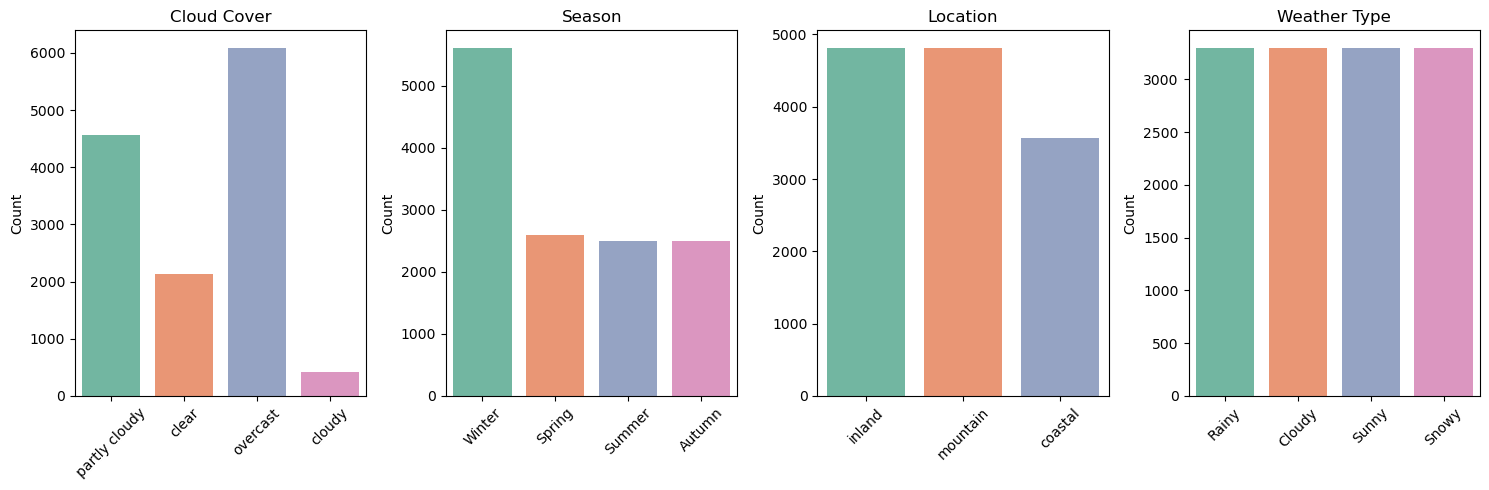

In [11]:
#Categorical Data Visualization
n_cols = 4
n_rows = math.ceil(len(categorical_features) / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
ax = ax.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, ax=ax[i], palette="Set2")
    ax[i].set_title(col)
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Count")

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

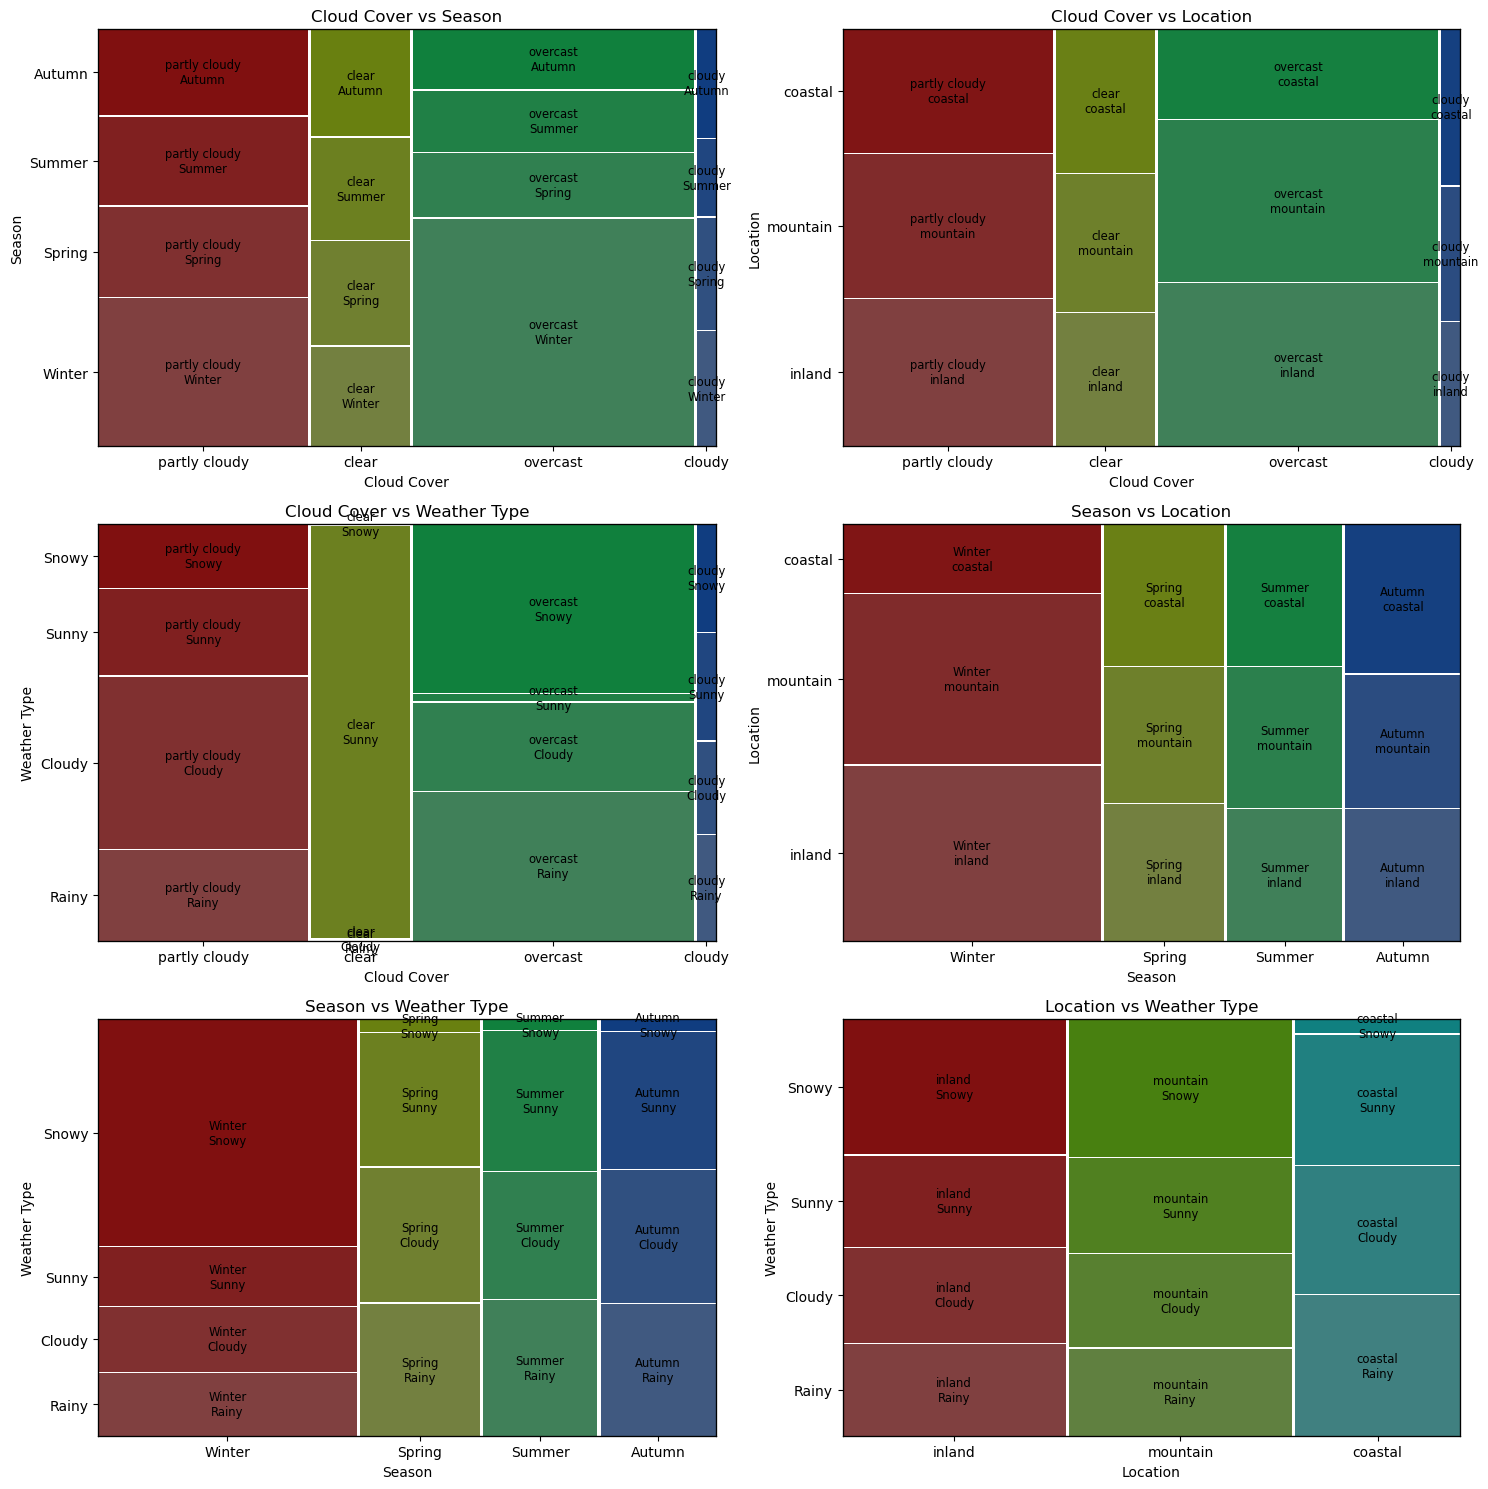

In [12]:
#Categorical Data Visualization
categorical_pairs = list(combinations(categorical_features, 2))
n_pairs = len(categorical_pairs)

n_cols = 2
n_rows = math.ceil(n_pairs / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
ax = ax.flatten()

for i, (col1, col2) in enumerate(categorical_pairs):
    mosaic(df, [col1, col2], ax=ax[i], title=f'{col1} vs {col2}')
    ax[i].set_xlabel(col1)
    ax[i].set_ylabel(col2)

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


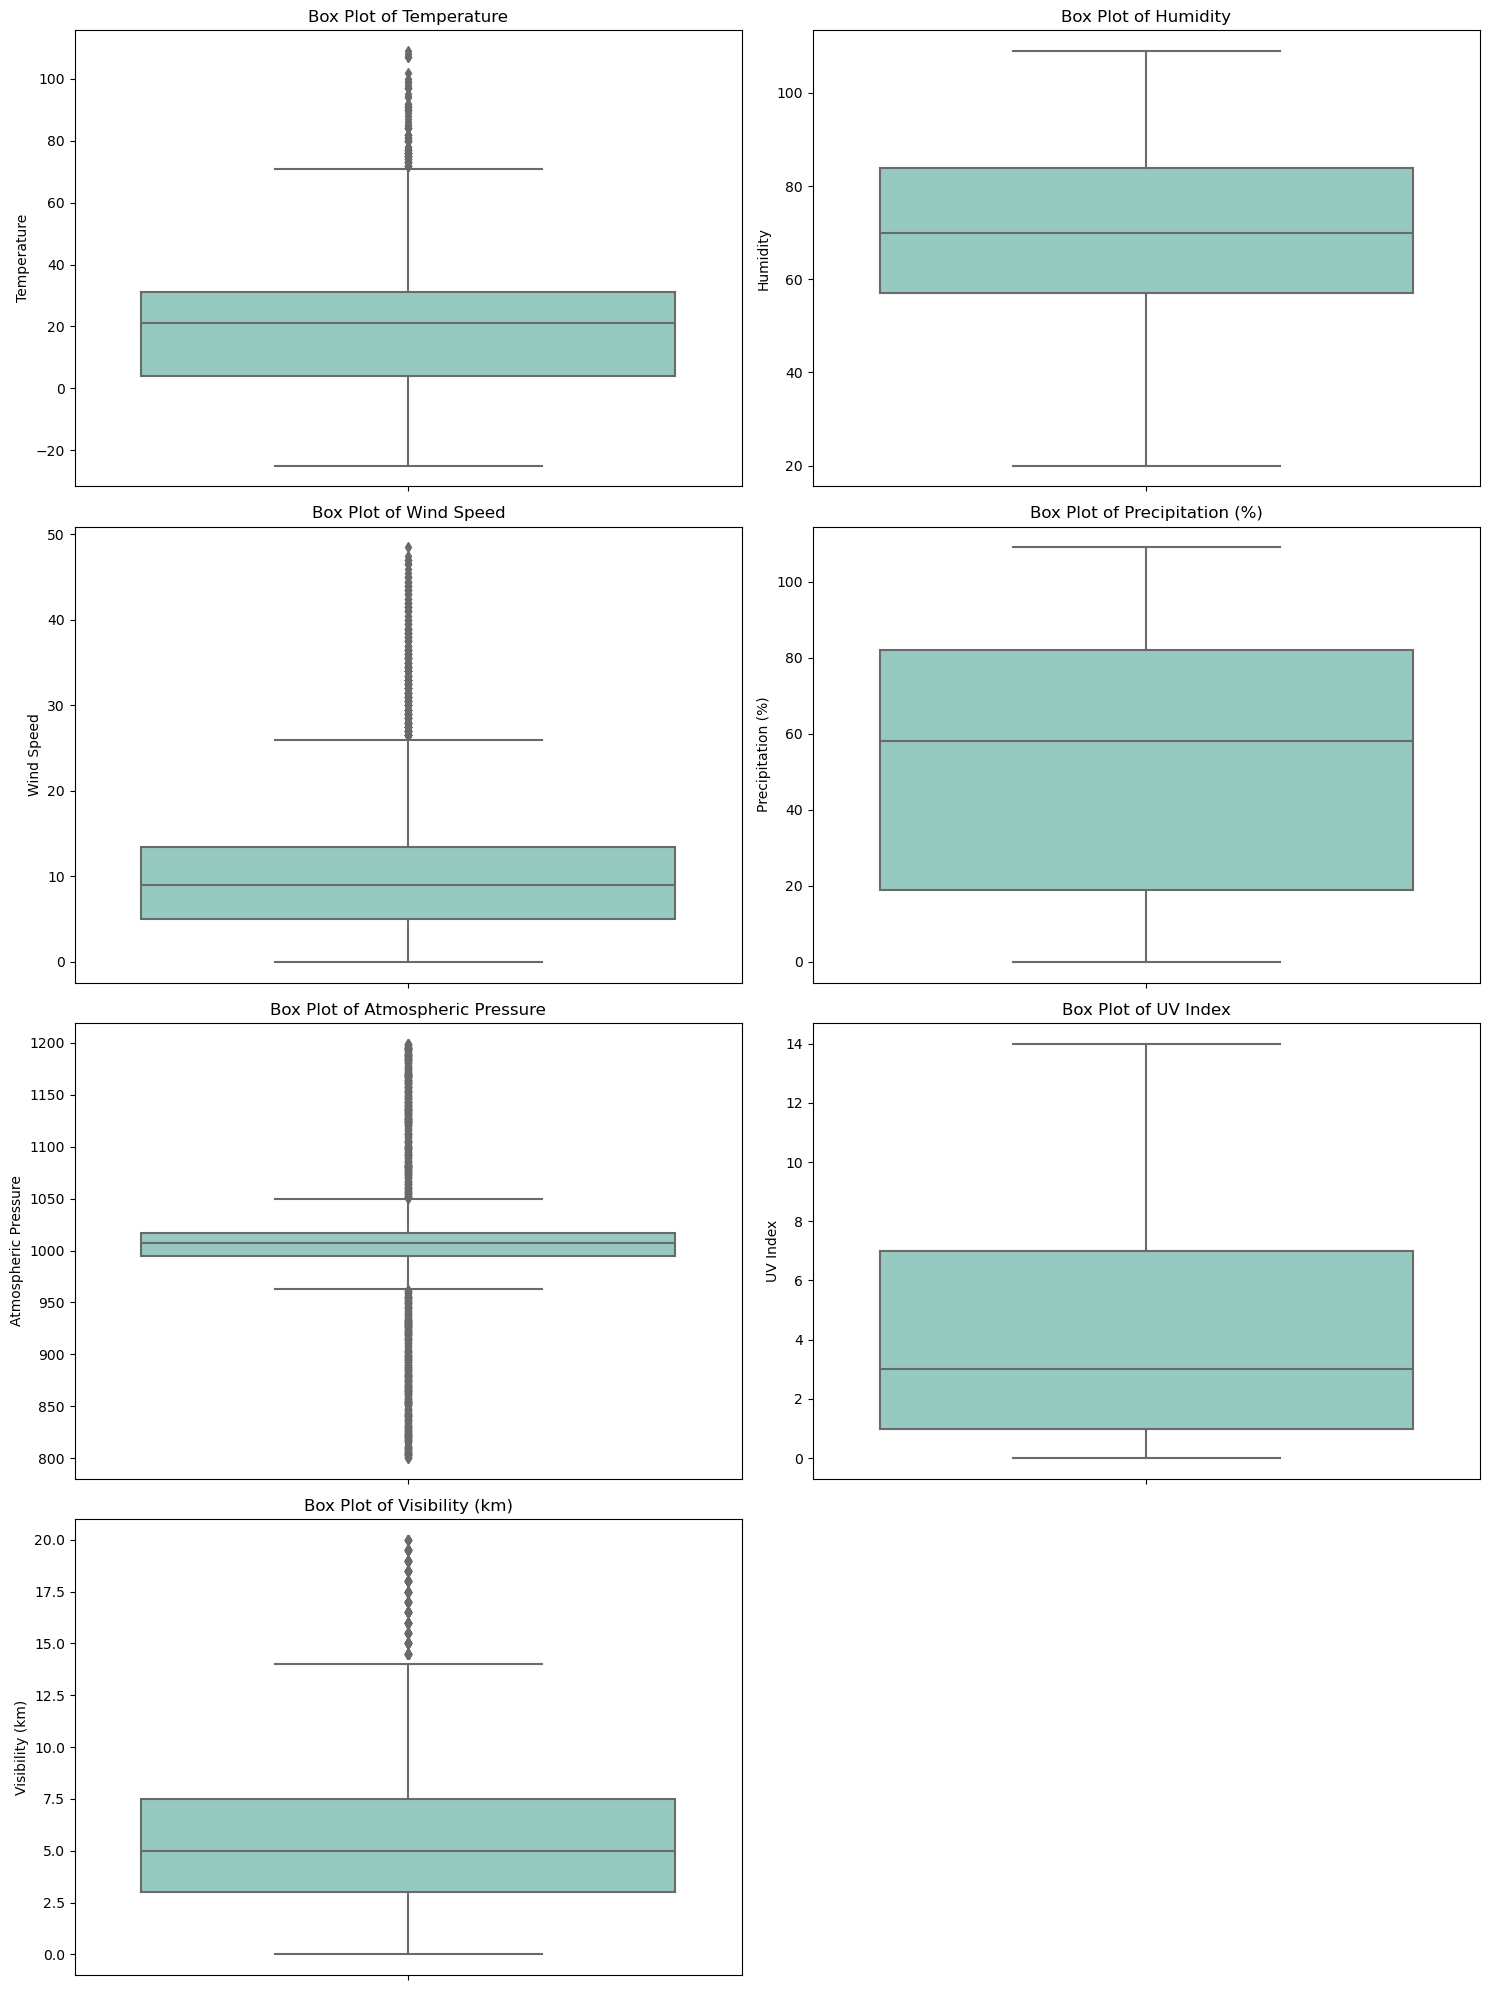

In [13]:
#Numerical Data Visualization
n_cols = 2
n_rows = math.ceil(len(numerical_features) / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
ax = ax.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=df, y=feature, ax=ax[i], palette="Set3")
    ax[i].set_title(f'Box Plot of {feature}')
    ax[i].set_xlabel('')

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

/Users/tahafaisal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tahafaisal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tahafaisal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tahafaisal/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

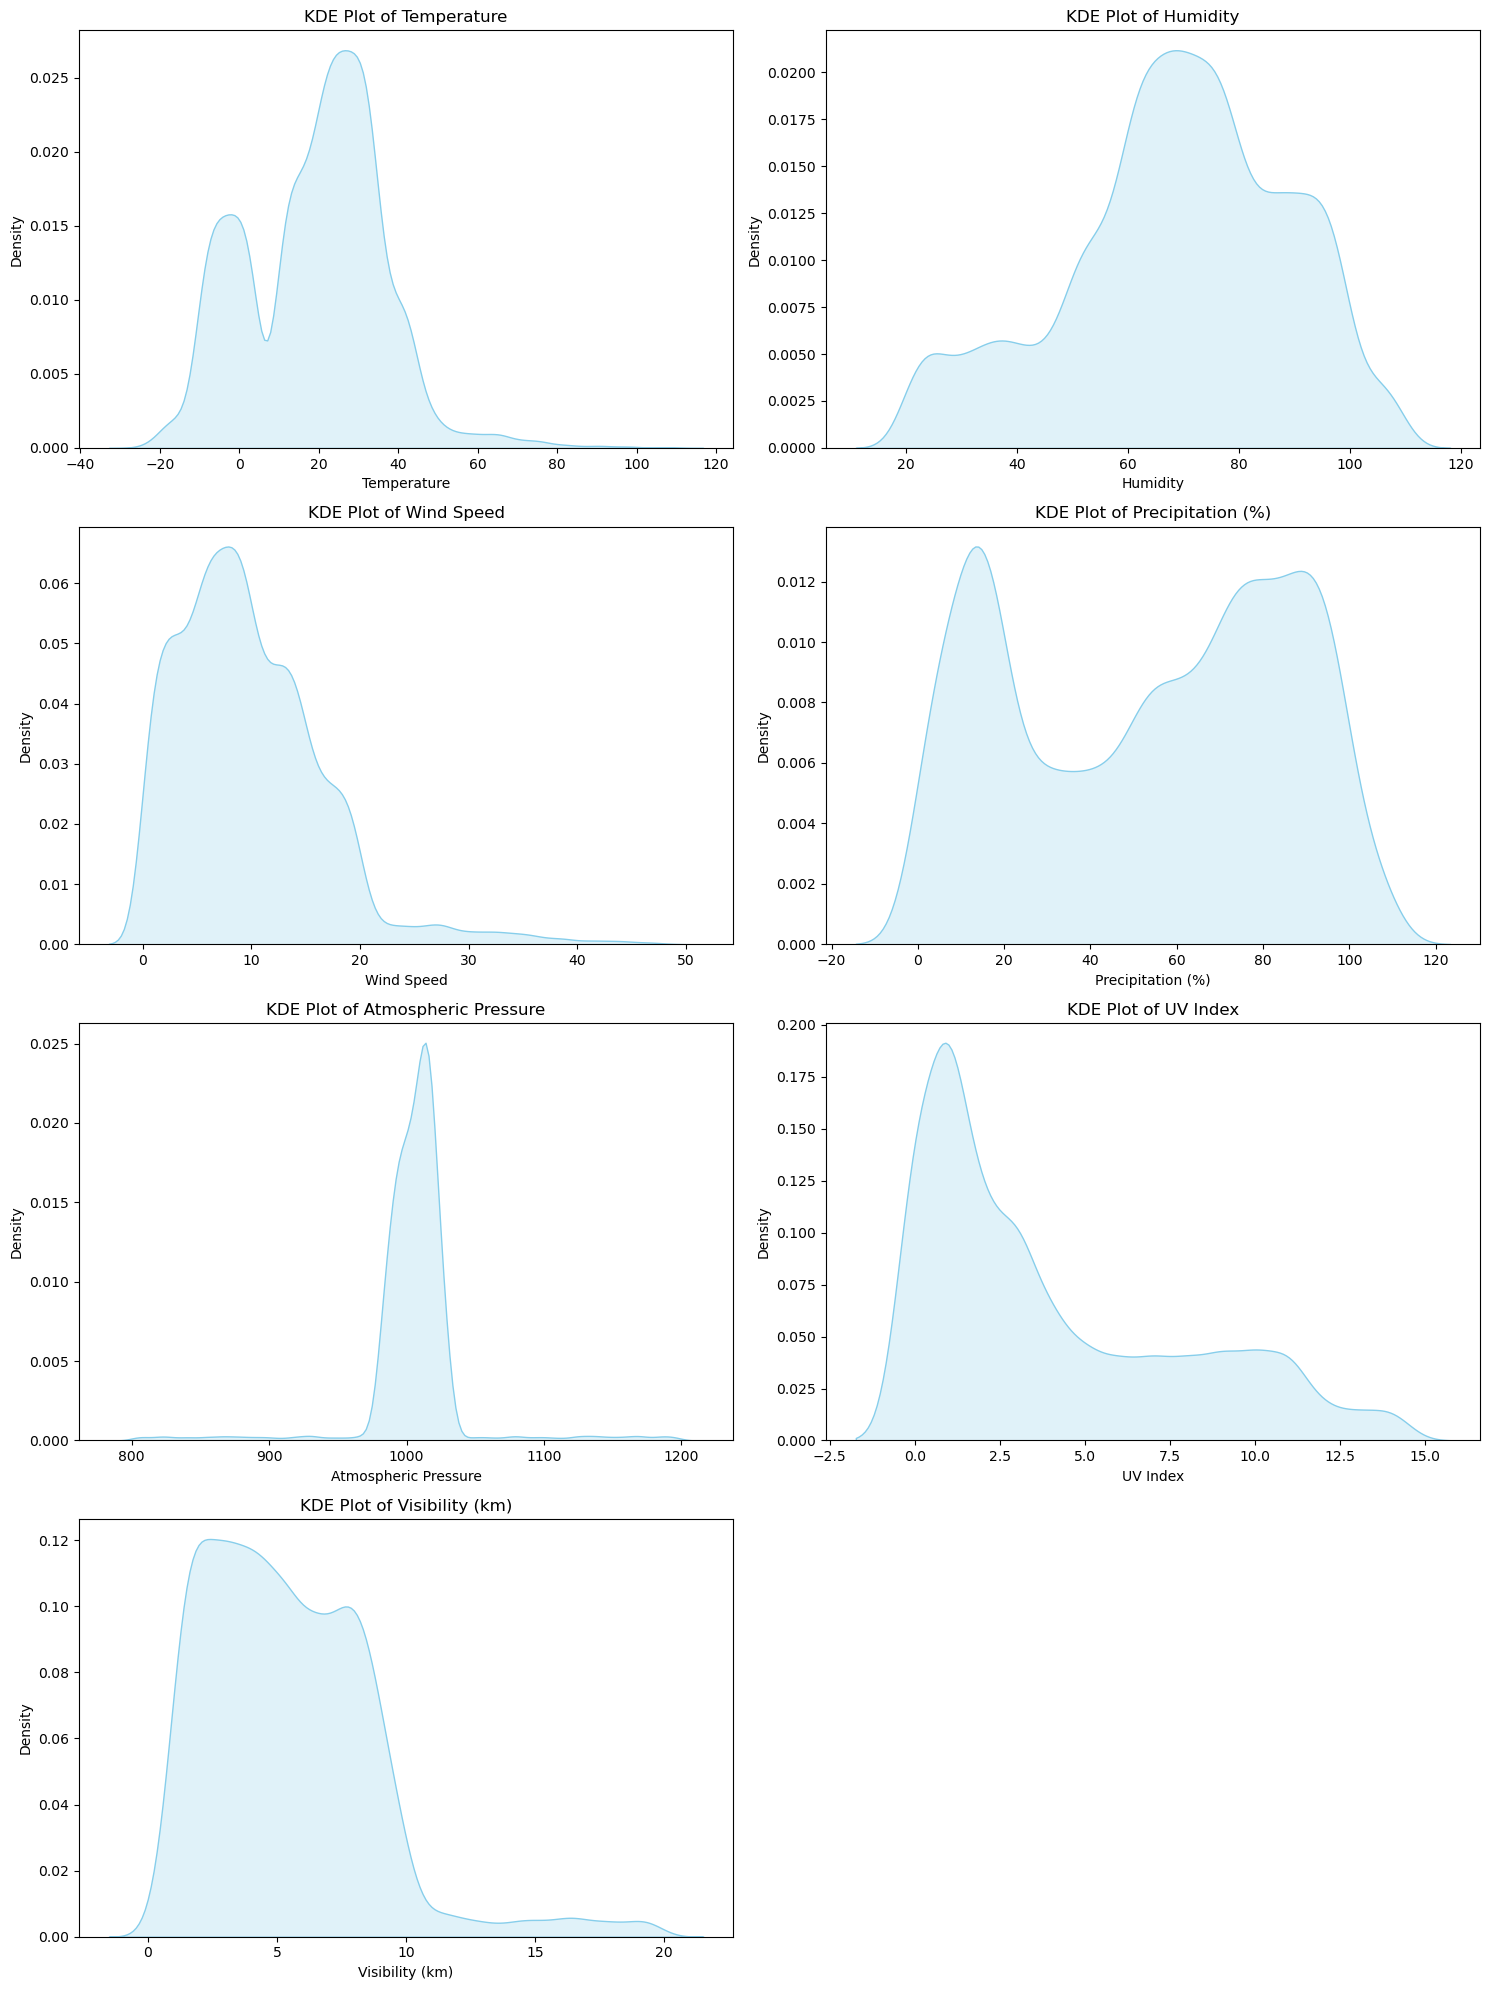

In [14]:
#Numerical Data Visualization
n_cols = 2
n_rows = math.ceil(len(numerical_features) / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
ax = ax.flatten()

for i, feature in enumerate(numerical_features):
    sns.kdeplot(data=df, x=feature, ax=ax[i], fill=True, color="skyblue")
    ax[i].set_title(f'KDE Plot of {feature}')
    ax[i].set_xlabel(feature)

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

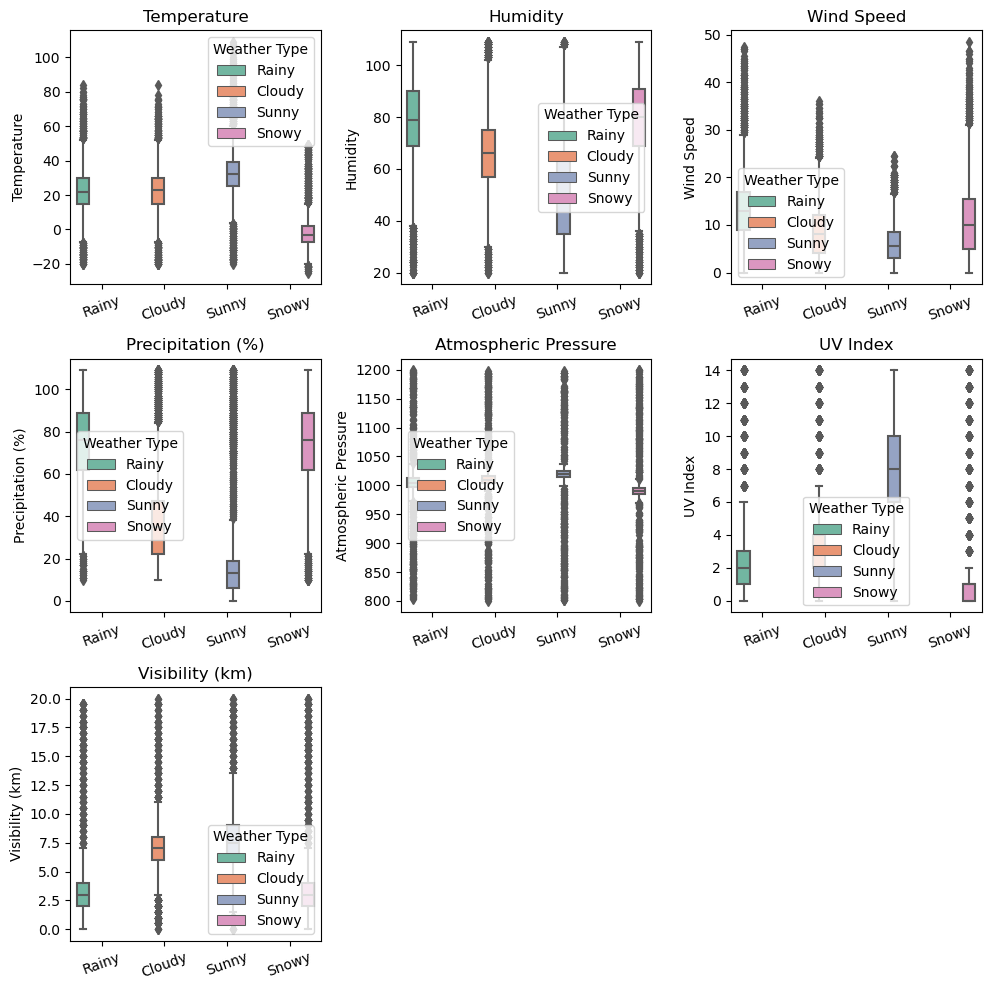

In [15]:
#Target/Numerical Relationship
n_cols = 3
n_rows = math.ceil(len(numerical_features) / n_cols)
target = categorical_features[3]

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 10))
ax = ax.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(data=df, x=target, y=col, hue=target, ax=ax[i], palette="Set2")
    ax[i].set_title(col)
    ax[i].tick_params(axis='x', rotation=20)
    ax[i].set_xlabel("")

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

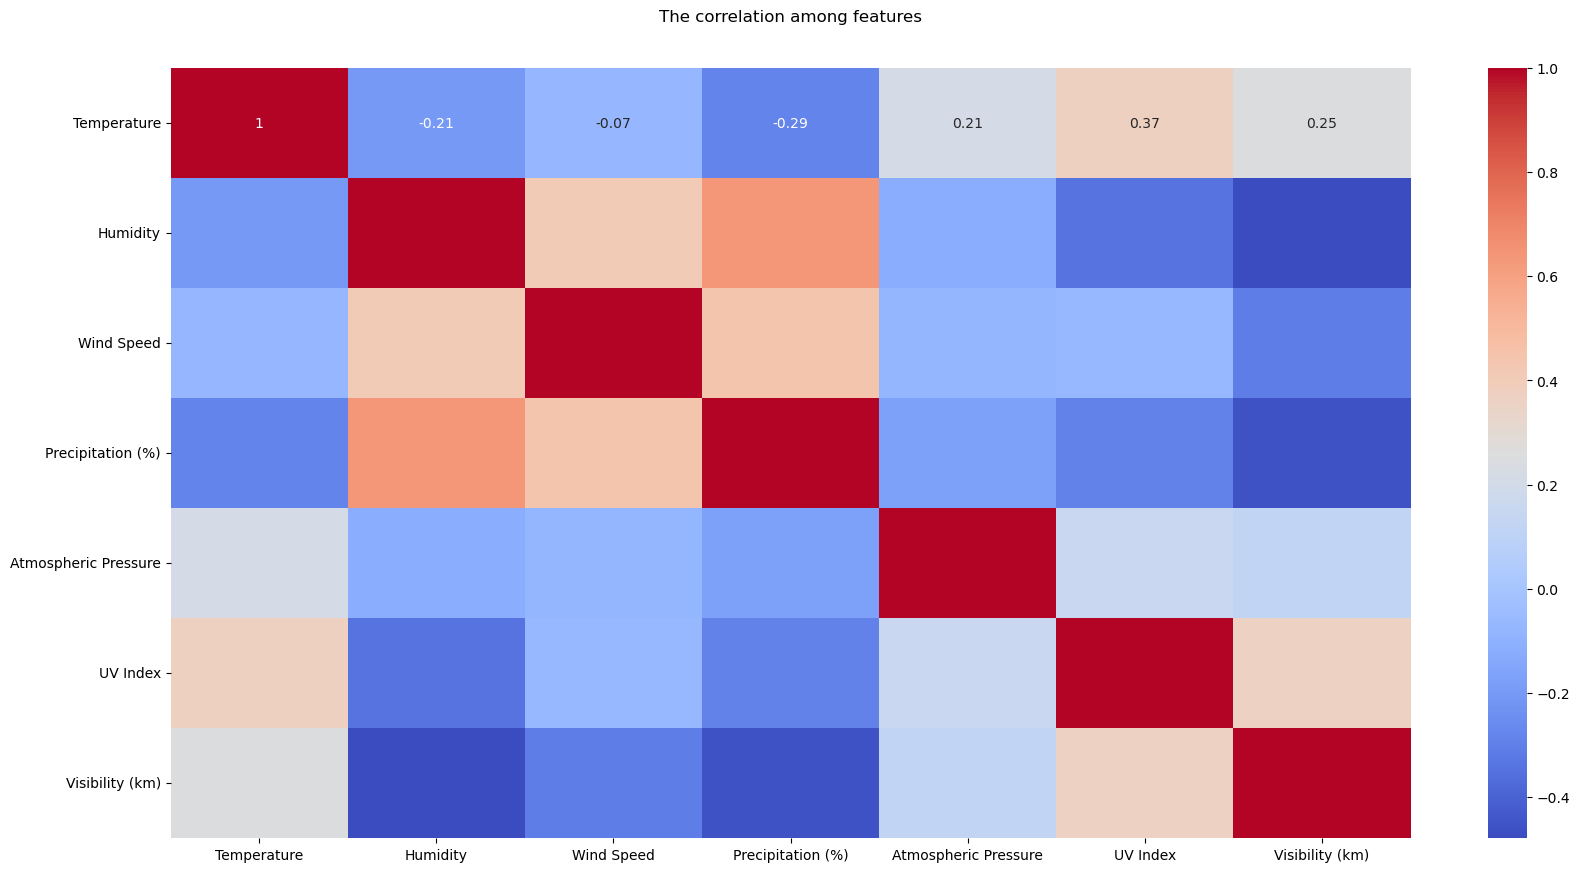

In [16]:
# Plotting a heatmap/correlation matrix
plt.figure(figsize=(20, 10))
df1 = df.select_dtypes(include='number') 
df1.dropna(inplace=True)
matrix = df1.corr()
sns.heatmap(matrix, annot=True,cmap = "coolwarm")
plt.title('The correlation among features',y= 1.05)
plt.show()

# Model Building

Using light gradient boosting to model this classification problem. LightGBM is based on gradient boosting, where models are built sequentially to correct errors made by previous models. It combines the predictions from multiple models to improve overall performance.

In [17]:
le_weather_type = LabelEncoder()
le_location = LabelEncoder()
le_cloud_cover = LabelEncoder()
le_season = LabelEncoder()

# Fit and transform each feature
df['Weather Type'] = le_weather_type.fit_transform(df['Weather Type'])
df['Location'] = le_location.fit_transform(df['Location'])
df['Cloud Cover'] = le_cloud_cover.fit_transform(df['Cloud Cover'])
df['Season'] = le_season.fit_transform(df['Season'])

In [18]:
X = df.drop('Weather Type', axis=1)
y = df['Weather Type']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [20]:
# Light Gradient Boosting
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 9240, number of used features: 10
[LightGBM] [Info] Start training from score -1.371256
[LightGBM] [Info] Start training from score -1.382837
[LightGBM] [Info] Start training from score -1.405085
[LightGBM] [Info] Start training from score -1.386294


In [21]:
print(accuracy_score(y_test, y_pred))


0.9131313131313131


[[853  56  25  21]
 [ 55 891  20  16]
 [ 23  16 974  20]
 [ 41  26  25 898]]


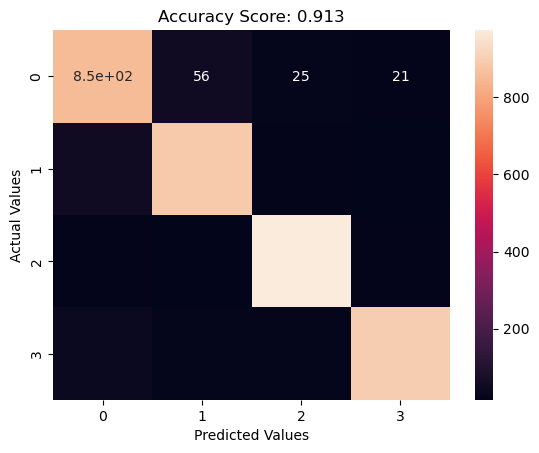

In [22]:
score = round(accuracy_score(y_test, y_pred), 3)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)
sns.heatmap(matrix, annot=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score))
plt.show()

In [23]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.89      0.89       955
           1       0.90      0.91      0.90       982
           2       0.93      0.94      0.94      1033
           3       0.94      0.91      0.92       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960



In [24]:
model = clf

save_dict = {
    'model': model,
    'label_encoders': {
        'weather_type': le_weather_type,
        'location': le_location,
        'cloud_cover': le_cloud_cover,
        'season': le_season
    }
}

with open('model_and_encoders.pkl', 'wb') as file:
    pickle.dump(save_dict, file)